In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

base_url = "https://milfordasset.com.au/wp-content/uploads/{year}/{month:02d}/Milford_Australian_Absolute_Growth_Fund_-_R_Class_{report_mon}{report_yy}.pdf"

months_to_generate = 10
today = datetime.today()

urls = []
for i in range(months_to_generate):
    upload_date = today - relativedelta(months=i)
    report_date = upload_date - relativedelta(months=1)

    url = base_url.format(
        year=upload_date.year,
        month=upload_date.month,
        report_mon=report_date.strftime("%b"),
        report_yy=report_date.strftime("%y"),
    )
    urls.append(url)

for u in urls:
    print(u)


https://milfordasset.com.au/wp-content/uploads/2025/10/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Sep25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/09/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Aug25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/08/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Jul25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/07/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Jun25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/06/Milford_Australian_Absolute_Growth_Fund_-_R_Class_May25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/05/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Apr25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/04/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Mar25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/03/Milford_Australian_Absolute_Growth_Fund_-_R_Class_Feb25.pdf
https://milfordasset.com.au/wp-content/uploads/2025/02/Milford_Australian_Absolu

GPT5 Prompt: Go to these URLs:

...
...

Task:
1. Open each PDF.
2. Extract the “Top Holdings” (or equivalent holdings table) showing each stock and its % of fund.
3. Add a column for the report date (the month-end shown in the PDF).
4. Combine all data into one table with columns:
   - Date
   - Stock
   - Percent of Fund
   - Link to Source 
5. Sort by Date descending, then Percent descending.
6. Export the final combined table as a CSV file.


In [23]:
import pandas as pd

df = pd.read_csv("milford.csv")


In [29]:
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df["Percent_num"] = df["Percent of Fund"].str.rstrip("%").astype(float)
# Notional in AUD millions (keep units consistent and readable)
df["Notional (M AUD)"] = df["Fund Size (M AUD)"] * df["Percent_num"] / 100.0

# Sanity checks (top-10 only, so sums won't be 100%)
by_date_summary = df.groupby("Date").agg(
    top10_weight_pct=("Percent_num", "sum"),
    fund_size_M=("Fund Size (M AUD)", "first"),
    top10_notional_M=("Notional (M AUD)", "sum")
).sort_index(ascending=True)

by_date_summary

,top10_weight_pct,fund_size_M,top10_notional_M
Date,,,
2024-12-31,30.83,466.3,143.76029
2025-01-31,27.95,477.4,133.43330
2025-02-28,26.99,459.4,123.99206
2025-03-31,24.52,446.4,109.45728
2025-04-30,24.62,452.1,111.30702
2025-05-31,27.79,454.0,126.16660
2025-06-30,26.71,459.9,122.83929
2025-07-31,27.58,467.9,129.04682
2025-08-31,26.89,474.4,127.56616


In [30]:
notional = df.pivot(index="Date", columns="Stock", values="Notional (M AUD)").fillna(0).sort_index()
weights  = df.pivot(index="Date", columns="Stock", values="Percent_num").fillna(0).sort_index()

# Month-over-month deltas (positive ~ buy/add, negative ~ sell/trim), aligned forward in time
notional_delta = notional.diff()  # Δ vs prior month
weight_delta   = weights.diff()

weight_delta


Stock,ALS,ANZ,ANZ Group Holdings,APA,Amcor,BHP,CSL,Car Group,Cleanaway Waste Management,Goodman,...,Rio Tinto,Santos,Spark,Teck Resources,Telstra,Viva Energy Group,Westpac,Woodside Energy Group,Woolworths,Xero
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-31,0.00,1.83,0.00,0.00,2.76,-0.38,-0.05,0.00,0.00,-2.34,...,0.00,-2.46,1.86,-0.4,-2.87,-0.02,0.00,0.00,-2.80,2.48
2025-02-28,0.00,-1.83,0.00,0.00,0.18,0.38,-0.92,2.01,0.00,0.00,...,2.42,0.00,-1.86,-1.9,0.00,-2.52,0.00,0.00,0.00,-0.34
2025-03-31,0.00,0.00,0.00,1.71,-0.37,-0.23,0.17,-2.01,0.00,1.82,...,-0.39,1.70,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-2.14
2025-04-30,0.00,0.00,0.00,0.06,-2.57,-0.83,0.85,0.00,0.00,-1.82,...,0.50,0.15,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2025-05-31,2.16,0.00,0.00,-1.77,0.00,-0.63,-1.01,0.00,2.45,0.00,...,1.24,1.34,0.00,0.0,0.00,0.00,0.00,0.00,1.98,2.54
2025-06-30,0.12,0.00,0.00,0.00,0.00,-0.38,1.57,0.00,-0.18,0.00,...,-1.75,-0.12,0.00,0.0,0.00,0.00,0.00,0.00,-0.07,-0.14
2025-07-31,0.34,0.00,2.07,0.00,0.00,1.80,0.72,0.00,-0.29,0.00,...,-0.04,-0.50,0.00,0.0,0.00,0.00,0.00,1.62,-1.91,-0.45
2025-08-31,-0.48,0.00,0.93,0.00,0.00,-0.11,-1.02,0.00,-1.98,0.00,...,0.03,-0.41,0.00,0.0,0.00,0.00,1.68,-1.62,0.00,-0.02


In [33]:
def stock_sets_at(date_idx, i):
    s = df.loc[df["Date"] == date_idx[i], "Stock"]
    return set(s)

dates = sorted(df["Date"].unique())
new_dropped = []
for i in range(1, len(dates)):
    prev_set = stock_sets_at(dates, i-1)
    cur_set  = stock_sets_at(dates, i)
    new_names     = sorted(cur_set - prev_set)
    dropped_names = sorted(prev_set - cur_set)
    if new_names or dropped_names:
        new_dropped.append({"Date": dates[i], "New": new_names, "Dropped": dropped_names})

new_dropped_df = pd.DataFrame(new_dropped)
new_dropped_df


,Date,New,Dropped
0,2025-01-31,"[ANZ, Amcor, Spark, Xero]","[Goodman, Santos, Telstra, Woolworths]"
1,2025-02-28,"[Car Group, Origin Energy, Resmed, Rio Tinto]","[ANZ, Spark, Teck Resources, Viva Energy Group]"
2,2025-03-31,"[APA, Goodman, Santos]","[Car Group, Macquarie, Xero]"
3,2025-04-30,"[Insignia Financial, Region RE]","[Amcor, Goodman]"
4,2025-05-31,"[ALS, Cleanaway Waste Management, Woolworths, ...","[APA, Insignia Financial, Origin Energy, Regio..."
5,2025-07-31,"[ANZ Group Holdings, Woodside Energy Group]","[Resmed, Woolworths]"
6,2025-08-31,"[Newmont, Region RE, Westpac]","[Cleanaway Waste Management, NAB, Woodside Ene..."
7,2025-09-30,"[Cleanaway Waste Management, Goodman, NAB]","[Region RE, Rio Tinto, Santos]"


In [35]:
abs_thresh_M = 5.0
wgt_thresh_pct = 0.50

trade_candidates = []
for i in range(1, len(notional.index)):
    dt = notional.index[i]
    delta_row_M = notional_delta.iloc[i]
    delta_row_w = weight_delta.iloc[i]
    for stock in notional.columns:
        dM = delta_row_M.get(stock, 0.0)
        dW = delta_row_w.get(stock, 0.0)
        if pd.notna(dM) and pd.notna(dW) and (abs(dM) > abs_thresh_M or abs(dW) > wgt_thresh_pct):
            trade_candidates.append({
                "Date": dt,
                "Stock": stock,
                "Δ Notional (M AUD)": round(dM, 3),
                "Δ Weight (pct-pts)": round(dW, 3),
                "Signal": "Add/Buy" if dM > 0 else "Trim/Sell"
            })

trades_df = pd.DataFrame(trade_candidates).sort_values(["Date","Δ Notional (M AUD)"], ascending=[True, False])
trades_df


,Date,Stock,Δ Notional (M AUD),Δ Weight (pct-pts),Signal
1,2025-01-31,Amcor,13.176,2.76,Add/Buy
8,2025-01-31,Xero,11.840,2.48,Add/Buy
5,2025-01-31,Spark,8.880,1.86,Add/Buy
0,2025-01-31,ANZ,8.736,1.83,Add/Buy
3,2025-01-31,Macquarie,-2.762,-0.65,Trim/Sell
...,...,...,...,...,...
59,2025-09-30,ANZ Group Holdings,-4.290,-0.55,Trim/Sell
64,2025-09-30,Region RE,-7.828,-1.65,Trim/Sell
65,2025-09-30,Rio Tinto,-9.535,-2.01,Trim/Sell
66,2025-09-30,Santos,-10.247,-2.16,Trim/Sell


In [37]:
turnover_weight = weight_delta.abs().sum(axis=1) / 2.0

# Notional turnover proxy as % of fund (top-10 slice only)
fund_size_by_date = df.drop_duplicates(["Date"])\
                      .set_index("Date")["Fund Size (M AUD)"].sort_index()
turnover_notional_pct = (notional_delta.abs().sum(axis=1) / fund_size_by_date).fillna(0) * 100.0

# Herfindahl-Hirschman Index of concentration for observed top-10 (weights only)
hhi = (weights.div(100.0)**2).sum(axis=1)
hhi

Date
2024-12-31    0.010317
2025-01-31    0.008799
2025-02-28    0.008043
2025-03-31    0.006910
2025-04-30    0.007113
2025-05-31    0.008185
2025-06-30    0.008273
2025-07-31    0.009593
2025-08-31    0.008566
2025-09-30    0.008254
dtype: float64

Text(0, 0.5, 'Percent-points')

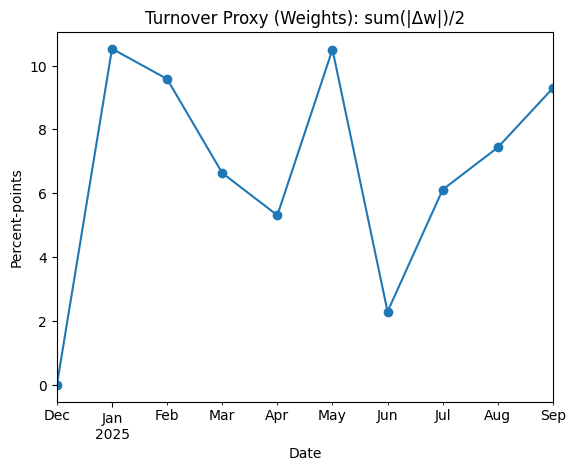

In [42]:
plt.figure()
turnover_weight.plot(marker="o", title="Turnover Proxy (Weights): sum(|Δw|)/2")
plt.xlabel("Date"); plt.ylabel("Percent-points")

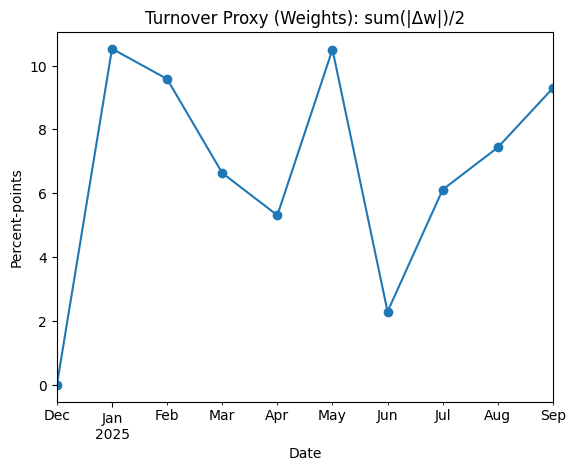

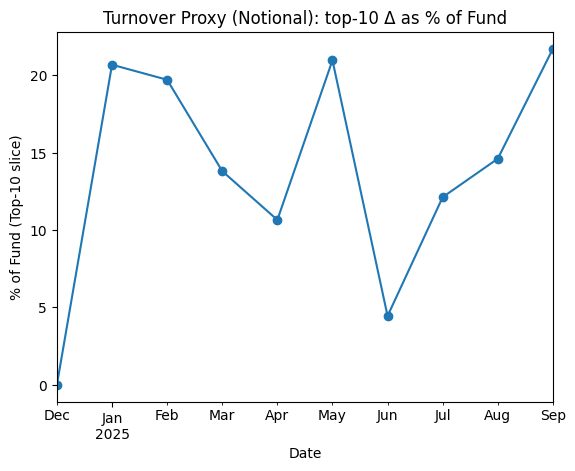

<Figure size 640x480 with 0 Axes>

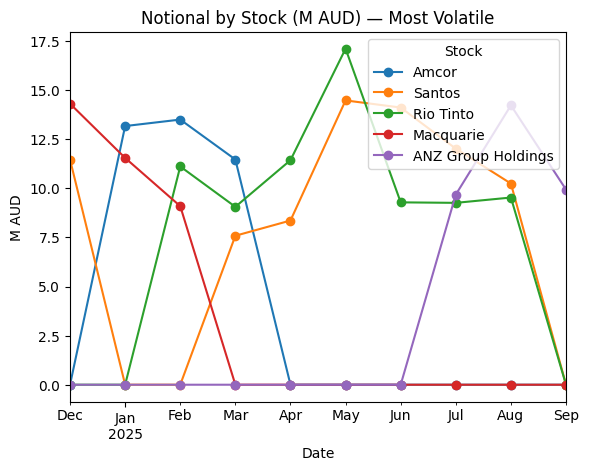

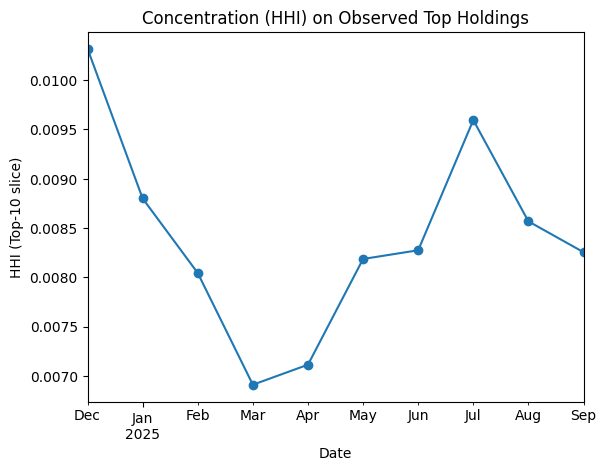


=== by_date_summary ===
            top10_weight_pct  fund_size_M  top10_notional_M
Date                                                       
2024-12-31             30.83        466.3         143.76029
2025-01-31             27.95        477.4         133.43330
2025-02-28             26.99        459.4         123.99206
2025-03-31             24.52        446.4         109.45728
2025-04-30             24.62        452.1         111.30702
2025-05-31             27.79        454.0         126.16660
2025-06-30             26.71        459.9         122.83929
2025-07-31             27.58        467.9         129.04682
2025-08-31             26.89        474.4         127.56616
2025-09-30             28.10        405.8         114.02980

=== new_dropped_df ===
        Date                                                New  \
0 2025-01-31                          [ANZ, Amcor, Spark, Xero]   
1 2025-02-28      [Car Group, Origin Energy, Resmed, Rio Tinto]   
2 2025-03-31                  

In [44]:
# --------------------------
# 6) Useful views
# --------------------------
# Top movers latest month
latest = dates[-1]
latest_moves = notional_delta.loc[latest].dropna().sort_values(ascending=False)
top_adds = latest_moves.head(5)
top_trims = latest_moves.tail(5)

# Most volatile names across the window (by std of notional)
volatility = notional.std().sort_values(ascending=False)
top_volatile = list(volatility.head(5).index)

# --------------------------
# 7) Plots (matplotlib only; one chart per figure; default colors)
# --------------------------
# a) Turnover proxy (weights)
plt.figure()
turnover_weight.plot(marker="o", title="Turnover Proxy (Weights): sum(|Δw|)/2")
plt.xlabel("Date"); plt.ylabel("Percent-points")

# b) Turnover proxy (notional as % of fund)
plt.figure()
turnover_notional_pct.plot(marker="o", title="Turnover Proxy (Notional): top-10 Δ as % of Fund")
plt.xlabel("Date"); plt.ylabel("% of Fund (Top-10 slice)")

# c) Notional over time for most volatile names
plt.figure()
notional[top_volatile].plot(marker="o", title="Notional by Stock (M AUD) — Most Volatile")
plt.xlabel("Date"); plt.ylabel("M AUD")
plt.legend(title="Stock")

# d) Concentration (HHI on observed set)
plt.figure()
hhi.plot(marker="o", title="Concentration (HHI) on Observed Top Holdings")
plt.xlabel("Date"); plt.ylabel("HHI (Top-10 slice)")

plt.show()

# --------------------------
# 8) Output tables you’ll likely inspect
# --------------------------
summary_outputs = {
    "by_date_summary": by_date_summary,                # sum of top-10 weights and top-10 notional each month
    "new_dropped_df": new_dropped_df,                  # new vs dropped names each month
    "trades_df_head": trades_df.head(30),              # top 30 flagged trades
    "top_adds_latest": top_adds,                       # biggest adds last month
    "top_trims_latest": top_trims,                     # biggest trims last month
    "most_volatile_names": volatility.head(10),        # volatility ranking (notional std)
}
for k, v in summary_outputs.items():
    print(f"\n=== {k} ==="); print(v)

<Axes: title={'center': 'Top Holdings Weight Over Time'}, xlabel='Date'>

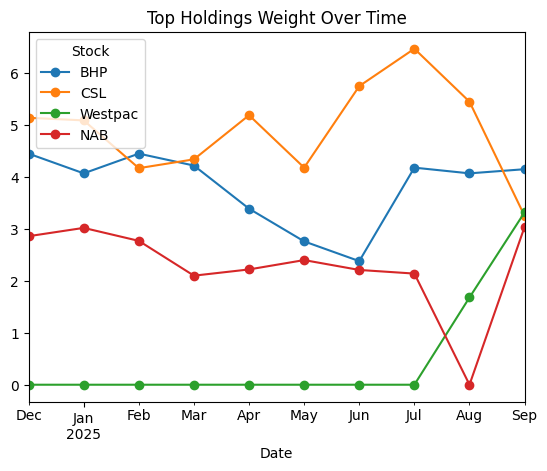

In [21]:
pivot[["BHP", "CSL", "Westpac", "NAB"]].plot(marker="o", title="Top Holdings Weight Over Time")


TODO: scrape their AUM data to work out position of each stock in portfolio
TODO: join with market data to see if selling is correlated overweight + benchmark overperformance 